# 导入包

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# 查看数据集前几行内容

In [2]:
features = pd.read_excel('D:\\typhoon(new).xlsx')

features.head()

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,TRACK_TYPE,DIST2LAND,USA_SSHS,STORM_SPEED,STORM_DIR,USA_WIND
0,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 00:00:00,TS,-12.5000,172.500,main,647,-1,6,351,25
1,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 03:00:00,TS,-12.1927,172.441,main,653,-1,6,351,25
2,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 06:00:00,TS,-11.9144,172.412,main,670,-1,5,358,25
3,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 09:00:00,TS,-11.6863,172.435,main,682,-1,4,12,25
4,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 12:00:00,TS,-11.5000,172.500,main,703,-1,4,22,25


## 数据表中
#### SID：一个台风的唯一编号
#### SEASON：台风的年份
#### NUMBER：该年内第几个台风
#### BASIN：台风事件发生的海域
#### SUBBASIN：对海域的进一步划分
#### NAME：台风名称
#### ISO_TIME：记录时间
#### NATURE：台风性质
#### TRACK_TYPE：台风轨迹类型
#### LAT：纬度
#### LON：经度
#### DIST2LAND：台风中心到地面的距离
#### STORM_SPEED：台风速度
#### STORM_DIR：台风方向
#### USA_WIND：一分钟平均最大持续风速
#### USA_SSHS：台风等级

In [10]:
print('数据维度：',features.shape)

数据维度： (287461, 16)


# 可视化

#### 每4年的台风数量

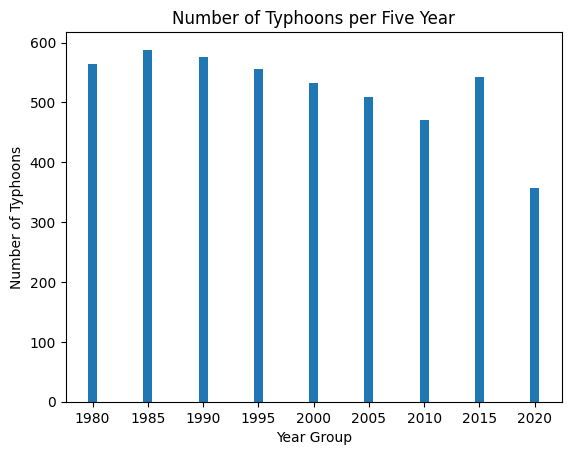

In [22]:
# 提取年份信息并添加新列"Year"
features['Year'] = pd.to_datetime(features['ISO_TIME']).dt.year

# 对"SID"列进行去重，只保留一条记录，即每个台风的第一次记录
features_unique = features.drop_duplicates(subset='SID')

# 将年份转换为每四年进行分组
features_unique['Year_Group'] = features_unique['Year'].apply(lambda x: (x // 5) * 5)

# 统计每个四年期间的台风数量
yearly_counts = features_unique['Year_Group'].value_counts().sort_index()

yearly_counts_df = pd.DataFrame({'Year Group': yearly_counts.index, 'Number of Typhoons': yearly_counts.values})
yearly_counts_df.to_csv(r'D:\five_counts.csv', index=False)

# 绘制柱状图显示每年的台风数量
plt.bar(yearly_counts.index, yearly_counts.values)
plt.xlabel('Year Group')
plt.ylabel('Number of Typhoons')
plt.title('Number of Typhoons per Five Year')
plt.xticks(yearly_counts.index)
plt.show()


#### 不同性质的台风的数量

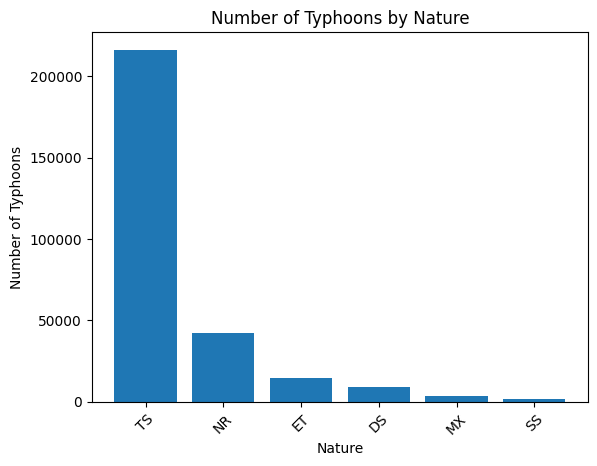

In [10]:
# 统计每种NATURE的台风数量
nature_counts = features['NATURE'].value_counts()

nature_counts_df = pd.DataFrame({'Nature': nature_counts.index, 'Count': nature_counts.values})
nature_counts_df.to_csv(r'D:\nature.csv', index=False)

# 绘制柱状图显示每种NATURE的台风数量
plt.bar(range(len(nature_counts)), nature_counts.values)
plt.xlabel('Nature')
plt.ylabel('Number of Typhoons')
plt.title('Number of Typhoons by Nature')
plt.xticks(range(len(nature_counts)), nature_counts.index, rotation=45)
plt.show()

#### 统计不同海域的台风数量

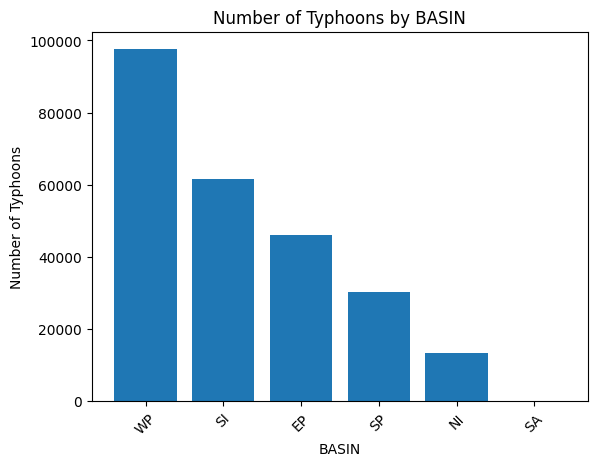

In [20]:
# 统计每种NATURE的台风数量
basin_counts = features['BASIN'].value_counts()

basin_counts_df = pd.DataFrame({'Basin': basin_counts.index, 'Count': basin_counts.values})
basin_counts_df.to_csv(r'D:\basin.csv', index=False)

# 绘制柱状图显示每种NATURE的台风数量
plt.bar(range(len(basin_counts)), basin_counts.values)
plt.xlabel('BASIN')
plt.ylabel('Number of Typhoons')
plt.title('Number of Typhoons by BASIN')
plt.xticks(range(len(basin_counts)), basin_counts.index, rotation=45)
plt.show()

# 使用LSTM模型

## 模型训练和验证

In [35]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
import tensorflow as tf
import joblib

# 选择需要的特征列
selected_features = ['BASIN', 'NATURE', 'TRACK_TYPE', 'LAT', 'LON', 'DIST2LAND', 'STORM_SPEED', 'STORM_DIR', 'USA_WIND', 'USA_SSHS']
features_selected = features[selected_features]
#features_selected.head()

# 独热编码
features_encoded = pd.get_dummies(features_selected, columns=['BASIN', 'NATURE', 'TRACK_TYPE'])
#features_encoded.head()
#print(features_encoded.dtypes)

X = features_encoded.values
#y = features_selected[['LAT', 'LON', 'USA_SSHS']].values.astype(float)
#y = features_selected[['LAT', 'LON']].values.astype(float)
y = features_selected[['LAT', 'LON','USA_WIND','DIST2LAND']].values.astype(float)

# 将数据集拆分为输入序列和输出序列
timesteps = 1
#timesteps = 5  # 输入序列长度，即前几个时间点的数据
X_sequence = []
y_sequence = []
#print(X[5])

n = len(X)
for i in range(timesteps, n-5):
    X_sequence.append(X[i-timesteps:i])
    y_sequence.append(y[i:i+5])
    
#print(X_sequence[5])
X_sequence = np.array(X_sequence).astype(np.float32)
y_sequence = np.array(y_sequence).astype(np.float32)

# 标准化X_sequence
scaler_X = StandardScaler()
X_sequence_scaled = scaler_X.fit_transform(X_sequence.reshape(-1, X_sequence.shape[-1])).reshape(X_sequence.shape)
#print(X_sequence_scaled[5])

# 标准化y_sequence
scaler_y = StandardScaler()
y_sequence_scaled = scaler_y.fit_transform(y_sequence.reshape(-1, y_sequence.shape[-1])).reshape(y_sequence.shape)
#print(y_sequence_scaled[5])

# 保存标准化参数
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

# 构建LSTM模型
model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, X_sequence.shape[2])))
model.add(RepeatVector(5))  # 重复向量5次，使输出形状为(?, 5, 64)
model.add(LSTM(64, return_sequences=True))  # 将输出形状再次设为(?, 5, 64)
model.add(TimeDistributed(Dense(3)))  # 每个时间步的输出形状为(?, 5, 3)
#model.add(TimeDistributed(Dense(2)))

# 编译模型
model.compile(optimizer='adam', loss='mse')

# 训练模型
model.fit(X_sequence_scaled, y_sequence_scaled, epochs=10, batch_size=32)

# 保存模型
model.save('lstm_model.h5')

Epoch 1/10
8983/8983 [==============================] - 40s 4ms/step - loss: 0.0917
Epoch 2/10
8983/8983 [==============================] - 39s 4ms/step - loss: 0.0801
Epoch 3/10
8983/8983 [==============================] - 40s 4ms/step - loss: 0.0785
Epoch 4/10
8983/8983 [==============================] - 41s 5ms/step - loss: 0.0772
Epoch 5/10
8983/8983 [==============================] - 40s 4ms/step - loss: 0.0763
Epoch 6/10
8983/8983 [==============================] - 41s 5ms/step - loss: 0.0755
Epoch 7/10
8983/8983 [==============================] - 37s 4ms/step - loss: 0.0748
Epoch 8/10
8983/8983 [==============================] - 39s 4ms/step - loss: 0.0741
Epoch 9/10
8983/8983 [==============================] - 38s 4ms/step - loss: 0.0736
Epoch 10/10
8983/8983 [==============================] - 38s 4ms/step - loss: 0.0731


## 模型验证

In [36]:
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

# 加载已训练的模型
model = load_model('lstm_model.h5')

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_sequence_scaled, y_sequence_scaled, test_size=0.00005, random_state=42)

# 使用验证集进行模型验证
val_predictions = model.predict(X_val)
val_predictions = scaler_y.inverse_transform(val_predictions.reshape(-1, y_sequence.shape[-1])).reshape(val_predictions.shape)

#可视化
timesteps = X_val.shape[1]
val_steps = y_val.shape[1]

# 对真实数据进行反标准化
y_val = scaler_y.inverse_transform(y_val.reshape(-1, y_sequence.shape[-1])).reshape(y_val.shape)

print(y_val)

# # 绘制纬度和经度的预测结果
# fig, axs = plt.subplots(val_steps, 2, figsize=(10, 5*val_steps))

# for i in range(val_steps):
#     axs[i, 0].plot(y_val[:, i, 0], label='True')
#     axs[i, 0].plot(val_predictions[:, i, 0], label='Predicted')
#     axs[i, 0].set_title('Latitude - Step {}'.format(i+1))
#     axs[i, 0].legend()
    
#     axs[i, 1].plot(y_val[:, i, 1], label='True')
#     axs[i, 1].plot(val_predictions[:, i, 1], label='Predicted')
#     axs[i, 1].set_title('Longitude - Step {}'.format(i+1))
#     axs[i, 1].legend()

# plt.tight_layout()
# plt.show()

1/1 [==============================] - 1s 566ms/step
[[[ 1.15166998e+01  1.25750000e+02  2.00000000e+01  2.40000725e+01]
  [ 1.17531996e+01  1.25578003e+02  2.00000000e+01  1.50000124e+01]
  [ 1.20699997e+01  1.25360001e+02  2.00000000e+01  1.20338555e-05]
  [ 1.24540997e+01  1.25162003e+02  2.00000000e+01  1.20338555e-05]
  [ 1.28332996e+01  1.24967003e+02  2.00000000e+01  3.30000114e+01]]

 [[ 1.72999992e+01 -1.03999992e+02  3.00000000e+01  1.23000015e+02]
  [ 1.75650005e+01 -1.03999992e+02  3.00000000e+01  9.40000153e+01]
  [ 1.77999992e+01 -1.03999992e+02  3.00000000e+01  7.59999542e+01]
  [ 1.80000000e+01 -1.03999992e+02  3.00000000e+01  6.20000114e+01]
  [ 1.82000008e+01 -1.03999992e+02  3.00000000e+01  5.30000114e+01]]

 [[ 3.16180992e+01  1.37319000e+02  6.20000000e+01  2.44000015e+02]
  [ 3.22999992e+01  1.37350006e+02  6.50000000e+01  1.93000015e+02]
  [ 3.29734993e+01  1.37391006e+02  6.50000000e+01  1.46000015e+02]
  [ 3.36250000e+01  1.37550003e+02  6.50000000e+01  1.01000

## 一个尝试

In [37]:
# 加载已训练的模型
model = tf.keras.models.load_model('lstm_model.h5')

# 输入数据
input_data = pd.DataFrame({
    'LAT': [-12.5],
    'LON': [172.5],
    'DIST2LAND': [647],
    'STORM_SPEED': [6],
    'STORM_DIR': [351],
    'USA_WIND': [25],
    'USA_SSHS': [-1],
    'BASIN_EP':[0],
    'BASIN_NI':[0],
    'BASIN_SA':[0],
    'BASIN_SI':[0],
    'BASIN_SP':[1],
    'BASIN_WP':[0],
    'NATURE_DS':[0],
    'NATURE_ET':[0],
    'NATURE_MX':[0],
    'NATURE_NR':[0],
    'NATURE_SS':[0],
    'NATURE_TS':[1],
    'TRACK_TYPE_PROVISIONAL':[0],
    'TRACK_TYPE_PROVISIONAL_spur':[0],
    'TRACK_TYPE_main':[1],
    'TRACK_TYPE_spur-merge':[0],
    'TRACK_TYPE_spur-other':[0],
    'TRACK_TYPE_spur-split':[0]
})

# 数据进行标准化
input_data_scaled = scaler_X.transform(input_data)

# 将输入数据转换为期望的形状
input_sequence = np.array([input_data_scaled])  # 形状：(1, timesteps, num_features)

# 预测输出
predicted_sequence_scaled = model.predict(input_sequence)  # 形状：(1, 5, num_features)
predicted_sequence_2d = np.reshape(predicted_sequence_scaled, (5, -1))  # 将其转换为二维数组 (5, num_features)
predicted_sequence = scaler_y.inverse_transform(predicted_sequence_2d)  # 反标准化

# 提取预测值

y1 = predicted_sequence[0]
y2 = predicted_sequence[1]
y3 = predicted_sequence[2]
y4 = predicted_sequence[3]
y5 = predicted_sequence[4]

# 输出结果
print("之后五个点的经纬度,速度和与地面距离:", y1, y2, y3, y4, y5)

# # 提取预测值
# lat_predictions = predicted_sequence[:, 0]  # 提取所有行的第一列（LAT）
# lon_predictions = predicted_sequence[:, 1]  # 提取第一行的所有列（LON）
# # 绘制图形
# plt.plot(lat_predictions, lon_predictions, marker='o')



# # 绘制输入点
# plt.scatter(input_data['LAT'], input_data['LON'], c='blue', label='Input', zorder=10)
# plt.plot([input_data['LAT'], y1[0]], [input_data['LON'], y1[1]], 'p-', label='Line')


# plt.xlabel('LAT')
# plt.ylabel('LON')
# plt.legend()

# plt.show()

1/1 [==============================] - 1s 611ms/step
之后五个点的经纬度,速度和与地面距离: [-11.699717 172.93968   25.60587  671.07654 ] [-12.275448 172.25629   25.49736  696.2881  ] [-11.853909 171.80228   25.231438 694.47833 ] [-11.479372 170.44585   25.447514 687.9352  ] [-11.165747 169.65858   25.830023 681.13293 ]
